In [491]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import os
from pathlib import Path
import ast

In [492]:
project_root = Path(os.getcwd())

users_path   = project_root / 'movie_users.csv'
df_users     = pd.read_csv(users_path)

conv_path   = project_root / 'movie_conversations.csv'
df_conv     = pd.read_csv(conv_path)

urrs_path   = project_root / 'movie_utterances.csv'
df_utts     = pd.read_csv(urrs_path)


In [493]:
bechd_path   = project_root / 'bechdel_movies_2023_FEB.csv'
df_bechd     = pd.read_csv(bechd_path)

In [494]:
df_temp = df_utts[["utterance_id", "speaker", "reply_to", "movie_id"]]
df_edges_short = df_temp.merge(
    df_temp,
    left_on="reply_to",
    right_on="utterance_id",
    suffixes=('_1', '_2'),
    how='inner'
)

df_edges_short = df_edges_short[["speaker_1", "speaker_2", "movie_id_1"]]
df_edges_short


,speaker_1,speaker_2,movie_id_1
0,u0,u2,m0
1,u0,u2,m0
2,u0,u2,m0
3,u0,u2,m0
4,u2,u0,m0
...,...,...,...
221611,u9030,u9034,m616
221612,u9034,u9030,m616
221613,u9030,u9034,m616
221614,u9034,u9030,m616


In [495]:
df_edges = df_edges_short.merge(
    df_users,
    left_on="speaker_1",
    right_on="user_id",
    how="inner",
)

df_edges = df_edges.rename(columns={'gender':'gender_1', 'character_name':'character_name_1'})
df_edges = df_edges[["speaker_1", "speaker_2", "movie_id_1", "gender_1", "character_name_1"]]

In [496]:
df_edges = df_edges.merge(
    df_users,
    left_on="speaker_2",
    right_on="user_id",
    how="inner",
)

df_edges = df_edges.rename(columns={'gender':'gender_2', 'character_name':'character_name_2'})
df_edges = df_edges[["speaker_1", "speaker_2", "movie_id_1", "gender_1", "character_name_1", "gender_2", "character_name_2"]]

In [497]:
cols_to_lower = ['gender_1', 'gender_2']
df_edges[cols_to_lower] = df_edges[cols_to_lower].apply(lambda col: col.str.lower())


In [498]:
df_edges

,speaker_1,speaker_2,movie_id_1,gender_1,character_name_1,gender_2,character_name_2
0,u0,u2,m0,f,BIANCA,m,CAMERON
1,u0,u2,m0,f,BIANCA,m,CAMERON
2,u0,u2,m0,f,BIANCA,m,CAMERON
3,u0,u2,m0,f,BIANCA,m,CAMERON
4,u2,u0,m0,m,CAMERON,f,BIANCA
...,...,...,...,...,...,...,...
221611,u9030,u9034,m616,?,DURNFORD,?,VEREKER
221612,u9034,u9030,m616,?,VEREKER,?,DURNFORD
221613,u9030,u9034,m616,?,DURNFORD,?,VEREKER
221614,u9034,u9030,m616,?,VEREKER,?,DURNFORD


In [499]:
df_meta = df_conv[["movie_idx", "movie_name", "release_year", "genre"]].drop_duplicates()

In [500]:
df_meta['movie_name'] = df_meta['movie_name'].apply(lambda col: col.lower())

df_bechd['title'] = df_bechd['title'].apply(lambda col: col.lower())
df_bechd['title'] = df_bechd['title'].replace(
    r'^(.*),\s*the$',
    r'the \1',
    regex=True
)
df_bechd["title"] = df_bechd["title"].str.replace("&#39;", "'", regex=False)

In [501]:
df_bechd

,title,year,rating,dubious,imdbid,id,submitterid,date,visible
0,passage de venus,1874,0,0.0,3155794,9602,18880,2021-04-02 20:58,1
1,la rosace magique,1877,0,0.0,14495706,9804,19145,2021-05-11 0:11,1
2,sallie gardner at a gallop,1878,0,0.0,2221420,9603,18882,2021-04-03 2:25,1
3,le singe musicien,1878,0,0.0,12592084,9806,19151,2021-05-11 23:38,1
4,athlete swinging a pick,1881,0,0.0,7816420,9816,19162,2021-05-13 1:32,1
...,...,...,...,...,...,...,...,...,...
9897,spider-man: no way home,2021,3,1.0,10872600,10166,19768,2021-12-21 02:14:30,1
9898,timeless,2018,3,0.0,5511582,10165,19766,2021-12-21 00:49:07,1
9899,red notice,2021,1,0.0,7991608,10164,19765,2021-12-20 14:10:11,1
9900,abbott and costello meet frankenstein,1948,3,0.0,40068,10163,19764,2021-12-19 18:11:42,1


In [502]:
df_meta['release_year'] = df_meta['release_year'].str.extract(r'(\d+)', expand=False)
df_meta['release_year'] = df_meta['release_year'].astype('Int64')
df_bechd['year'] = df_bechd['year'].astype('Int64')
df_meta = df_meta.merge(
    df_bechd,
    left_on=["movie_name", "release_year"],
    right_on=["title", "year"],
    how="left",
)

df_meta = df_meta[["movie_idx", "movie_name", "release_year", "genre", "rating"]].drop_duplicates()


In [503]:
df_meta

,movie_idx,movie_name,release_year,genre,rating
0,m0,10 things i hate about you,1999,"['comedy', 'romance']",3.0
1,m1,1492: conquest of paradise,1992,"['adventure', 'biography', 'drama', 'history']",NaN
2,m2,15 minutes,2001,"['action', 'crime', 'drama', 'thriller']",NaN
3,m3,2001: a space odyssey,1968,"['adventure', 'mystery', 'sci-fi']",0.0
4,m4,48 hrs.,1982,"['action', 'comedy', 'crime', 'drama', 'thrill...",2.0
...,...,...,...,...,...
612,m612,watchmen,2009,"['action', 'crime', 'fantasy', 'mystery', 'sci...",3.0
613,m613,xxx,2002,"['action', 'adventure', 'crime']",1.0
614,m614,x-men,2000,"['action', 'sci-fi']",1.0
615,m615,young frankenstein,1974,"['comedy', 'sci-fi']",2.0


In [504]:
df_meta = df_meta.rename(columns={'rating':'bechdel_score'})

In [505]:
df_meta['genre'] = df_meta['genre'].apply(ast.literal_eval)
df_meta

,movie_idx,movie_name,release_year,genre,bechdel_score
0,m0,10 things i hate about you,1999,"[comedy, romance]",3.0
1,m1,1492: conquest of paradise,1992,"[adventure, biography, drama, history]",NaN
2,m2,15 minutes,2001,"[action, crime, drama, thriller]",NaN
3,m3,2001: a space odyssey,1968,"[adventure, mystery, sci-fi]",0.0
4,m4,48 hrs.,1982,"[action, comedy, crime, drama, thriller]",2.0
...,...,...,...,...,...
612,m612,watchmen,2009,"[action, crime, fantasy, mystery, sci-fi, thri...",3.0
613,m613,xxx,2002,"[action, adventure, crime]",1.0
614,m614,x-men,2000,"[action, sci-fi]",1.0
615,m615,young frankenstein,1974,"[comedy, sci-fi]",2.0


In [506]:
df_edges = df_edges.rename(columns={'movie_id_1': 'movie_id'})
df_meta = df_meta.rename(columns={'movie_idx': 'movie_id'})
meta_dict = df_meta.set_index('movie_id').to_dict(orient='index')
df_edges = df_edges[df_edges['movie_id'].isin(df_meta['movie_id'])]


df_grouped = (
    df_edges
      .groupby(['movie_id', 'speaker_1', 'speaker_2'])
      .size()
      .reset_index(name='weight')
)


In [507]:
graphs_by_movie = {}

for mid, sub_df in df_grouped.groupby('movie_id'):
    G = nx.Graph()

    df_this_movie_users = df_users[df_users['movie_idx'] == mid]
    id_to_name   = df_this_movie_users.set_index('user_id')['character_name'].to_dict()
    id_to_gender = df_this_movie_users.set_index('user_id')['gender'].to_dict()

    unique_speakers = set(sub_df['speaker_1']).union(sub_df['speaker_2'])

    for uid in unique_speakers:
        char_name = id_to_name.get(uid, uid)
        gender    = id_to_gender.get(uid, '?')
        G.add_node(uid,
                   character_name=char_name,
                   gender=gender)

    for _, row in sub_df.iterrows():
        u = row['speaker_1']
        v = row['speaker_2']
        w = row['weight']
        if G.has_edge(u, v):
            G[u][v]['weight'] += w
        else:
            G.add_edge(u, v, weight=w)

    total_weight = sum(data['weight'] for _, _, data in G.edges(data=True))
    if total_weight > 0:
        for u, v, data in G.edges(data=True):
            data['weight'] = round(data['weight'] / total_weight, 2)

    if mid in meta_dict:
        G.graph['movie_name']   = meta_dict[mid]['movie_name']
        G.graph['release_year'] = meta_dict[mid]['release_year']
        G.graph['genre']        = meta_dict[mid]['genre']
        G.graph['bechdel_score']= meta_dict[mid]['bechdel_score']
    else:
        G.graph['movie_name']   = None
        G.graph['release_year'] = None
        G.graph['genre']        = None
        G.graph['bechdel_score']= None

    graphs_by_movie[mid] = G

### Print graph by Movie_id

In [508]:
def plot_movie_graph_with_node_attrs(movie_id,
                                     node_size=800,
                                     edge_width_factor=15):

    if movie_id not in graphs_by_movie:
        print(f"No graph found for movie_id {movie_id}")
        return

    G = graphs_by_movie[movie_id]
    movie_name = G.graph.get('movie_name', 'Unknown')

    node_colors = []
    labels = {}
    for uid, attrdict in G.nodes(data=True):
        gender = attrdict.get('gender', '?').lower()
        if gender == 'f':
            node_colors.append('#ff69b4')
        elif gender == 'm':
            node_colors.append('#1f77b4')
        else:
            node_colors.append('gray')
        labels[uid] = attrdict.get('character_name', uid)

    plt.figure(figsize=(6,6))
    pos = nx.spring_layout(G, seed=42)

    nx.draw_networkx_nodes(
        G, pos,
        node_size=node_size,
        node_color=node_colors
    )

    widths = []
    for u, v, data in G.edges(data=True):
        w = data.get('weight', 0)
        widths.append(w * edge_width_factor)

    nx.draw_networkx_edges(
        G, pos,
        width=widths,
        edge_color='gray',
        alpha=0.7
    )
    nx.draw_networkx_labels(
        G, pos,
        labels=labels,
        font_size=8
    )
    plt.title(f"Conversation Graph for \"{movie_name}\"", fontsize=10)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

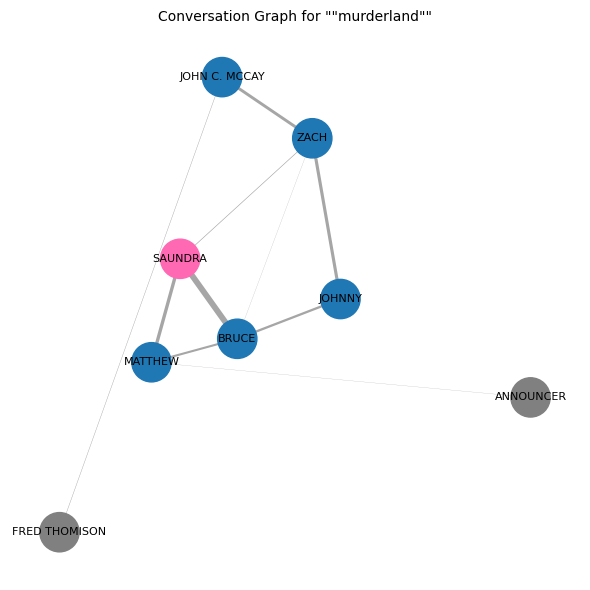

In [525]:
mid = df_conv["movie_idx"].sample(n=1).iloc[0]
plot_movie_graph_with_node_attrs(mid)

In [510]:
records = []
for mid, G in graphs_by_movie.items():
    records.append({
        'movie_id':       mid,
        'bechdel_score':  G.graph.get('bechdel_score'),
        'release_year':   G.graph.get('release_year'),
        'genre':          G.graph.get('genre', [])
    })

df_post_meta = pd.DataFrame(records)

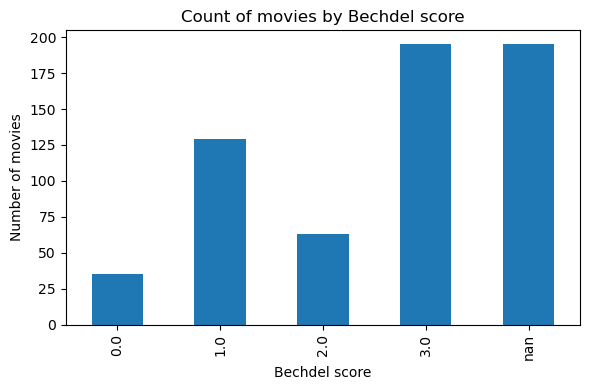

In [511]:
bechdel_counts = (
    df_post_meta['bechdel_score']
    .value_counts(dropna=False)
    .sort_index()
)

plt.figure(figsize=(6,4))
bechdel_counts.plot(kind='bar')
plt.xlabel('Bechdel score')
plt.ylabel('Number of movies')
plt.title('Count of movies by Bechdel score')
plt.tight_layout()
plt.show()


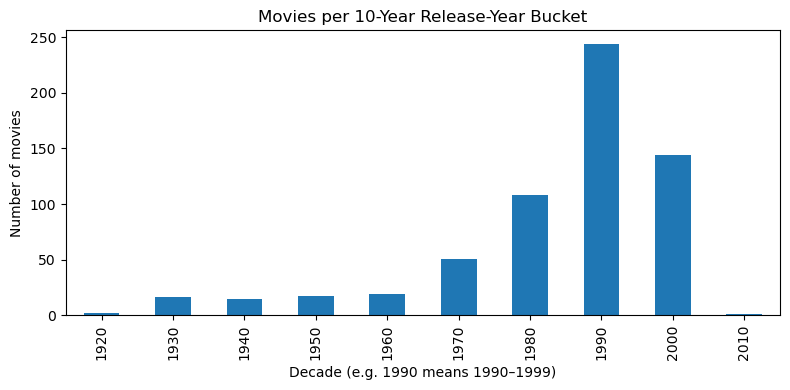

In [512]:
df_year = df_post_meta.dropna(subset=['release_year']).copy()

df_year['decade'] = (df_year['release_year'] // 10) * 10
decade_counts = df_year['decade'].value_counts().sort_index()

plt.figure(figsize=(8,4))
decade_counts.plot(kind='bar')
plt.xlabel('Decade (e.g. 1990 means 1990–1999)')
plt.ylabel('Number of movies')
plt.title('Movies per 10‐Year Release‐Year Bucket')
plt.tight_layout()
plt.show()

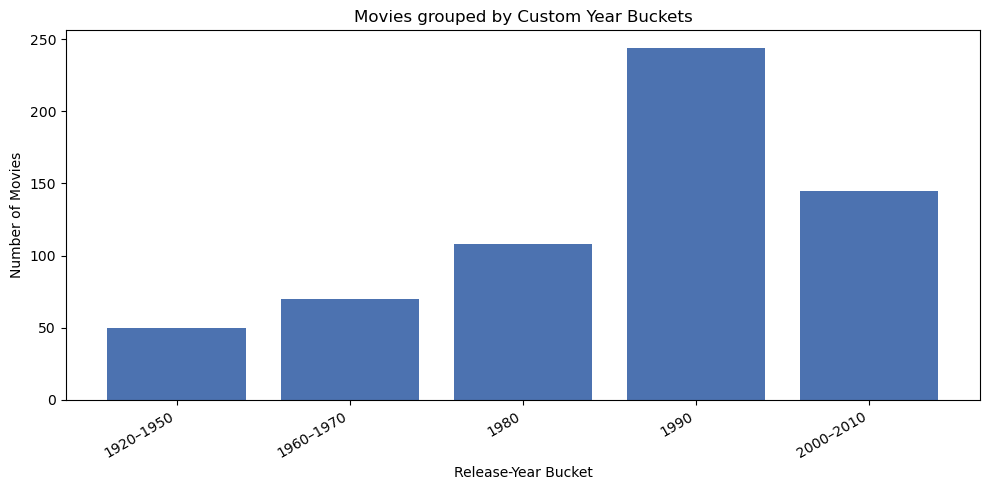

In [513]:
df_year = df_post_meta.dropna(subset=['release_year']).copy()

def to_custom_bucket(year):
    dec = (int(year) // 10) * 10
    if 1920 <= dec <= 1950:
        return '1920–1950'
    elif 1960 <= dec <= 1970:
        return '1960–1970'
    elif 2000 <= dec <= 2010:
        return '2000–2010'
    else:
        return str(dec)

df_year['bucket'] = df_year['release_year'].apply(to_custom_bucket)

bucket_counts = (
    df_year['bucket']
    .value_counts()
    .reset_index(name='count')
    .rename(columns={'index': 'bucket'})
)

def bucket_sort_key(bucket_label):
    if '–' in bucket_label:
        first_part = bucket_label.split('–')[0]
        return int(first_part)
    else:
        return int(bucket_label)

bucket_counts['sort_key'] = bucket_counts['bucket'].apply(bucket_sort_key)
bucket_counts = bucket_counts.sort_values('sort_key', ascending=True).reset_index(drop=True)
bucket_counts = bucket_counts.drop(columns=['sort_key'])

plt.figure(figsize=(10, 5))
plt.bar(bucket_counts['bucket'], bucket_counts['count'], color='#4C72B0')
plt.xlabel('Release‐Year Bucket')
plt.ylabel('Number of Movies')
plt.title('Movies grouped by Custom Year Buckets')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

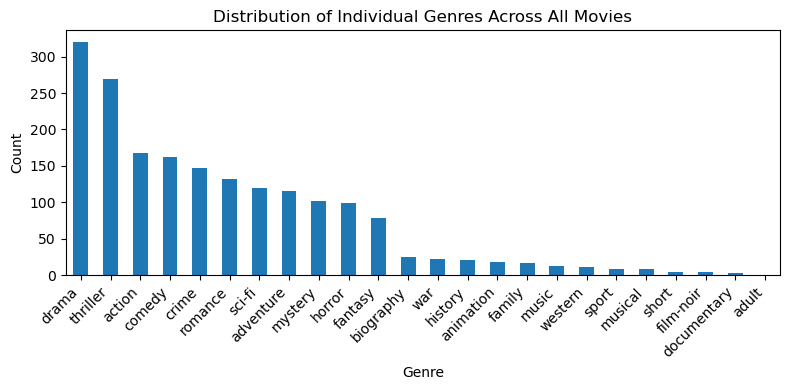

In [514]:
df_exploded = df_post_meta.explode('genre')
genre_counts = df_exploded['genre'].value_counts()

plt.figure(figsize=(8,4))
genre_counts.plot(kind='bar')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Distribution of Individual Genres Across All Movies')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [515]:
import numpy as np

node_counts = []
edge_counts = []
known_gender_percents = []

for mid, G in graphs_by_movie.items():
    n_nodes = G.number_of_nodes()
    n_edges = G.number_of_edges()
    node_counts.append(n_nodes)
    edge_counts.append(n_edges)

    n_known = sum(
        1
        for _, attr in G.nodes(data=True)
        if attr.get('gender') not in (None, '?')
    )
    pct_known = (n_known / n_nodes) * 100 if n_nodes > 0 else 0
    known_gender_percents.append(pct_known)

node_counts = np.array(node_counts)
edge_counts = np.array(edge_counts)
known_gender_percents = np.array(known_gender_percents)


avg_nodes              = node_counts.mean()                if node_counts.size > 0              else 0
avg_edges              = edge_counts.mean()                if edge_counts.size > 0              else 0
avg_known_gender_pct   = known_gender_percents.mean()      if known_gender_percents.size > 0    else 0

median_nodes           = np.median(node_counts)            if node_counts.size > 0              else 0
median_edges           = np.median(edge_counts)            if edge_counts.size > 0              else 0
median_known_gender_pct = np.median(known_gender_percents) if known_gender_percents.size > 0    else 0

min_nodes, max_nodes        = (node_counts.min(), node_counts.max())             if node_counts.size > 0           else (0, 0)
min_edges, max_edges        = (edge_counts.min(), edge_counts.max())             if edge_counts.size > 0           else (0, 0)
min_known_pct, max_known_pct = (known_gender_percents.min(), known_gender_percents.max()) if known_gender_percents.size > 0 else (0, 0)


print(f"Computed over {len(graphs_by_movie)} movies:")
print(f"  • Average number of nodes per movie:                  {avg_nodes:.2f}")
print(f"  • Median number of nodes per movie:                   {median_nodes:.0f}")
print(f"  • Min/Max nodes per movie:                            {min_nodes} / {max_nodes}")
print()
print(f"  • Average number of edges per movie:                  {avg_edges:.2f}")
print(f"  • Median number of edges per movie:                   {median_edges:.0f}")
print(f"  • Min/Max edges per movie:                            {min_edges} / {max_edges}")
print()
print(f"  • Average % of nodes with known gender per movie:     {avg_known_gender_pct:.2f}%")
print(f"  • Median % of nodes with known gender per movie:      {median_known_gender_pct:.0f}%")
print(f"  • Min/Max % of nodes with known gender per movie:     {min_known_pct:.0f}% / {max_known_pct:.0f}%")


Computed over 617 movies:
  • Average number of nodes per movie:                  14.64
  • Median number of nodes per movie:                   14
  • Min/Max nodes per movie:                            2 / 44

  • Average number of edges per movie:                  17.26
  • Median number of edges per movie:                   17
  • Min/Max edges per movie:                            1 / 59

  • Average % of nodes with known gender per movie:     35.06%
  • Median % of nodes with known gender per movie:      33%
  • Min/Max % of nodes with known gender per movie:     0% / 86%
